In [1]:
# importing frequently used packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing pytorch related packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
import torchvision.transforms as transforms

In [2]:
# check if CUDA is available and print GPU info
use_cuda = torch.cuda.is_available()
print(use_cuda)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

# set device to use GPU if available, otherwise use CPU
device = torch.device('cuda:0' if use_cuda else 'cpu')

True
1
0
Tesla T4


In [3]:
# Define the custom dataset
class MyDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.data.iloc[index, :-1].values, dtype=torch.float32)
        y = torch.tensor(self.data.iloc[index, -1], dtype=torch.float32)
        return x, y

In [4]:
# Load the dataset
dataset = MyDataset('/content/drive/MyDrive/Colab Notebooks/Data.csv')

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [6]:
# Define the model class
class MyModule(nn.Module):
    def __init__(self, layer_sizes=[6, 10, 1], activations=[nn.LeakyReLU()], dropouts=[0.5]):
        super(MyModule, self).__init__()

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(activations):
                layers.append(activations[i])
            if i < len(dropouts):
                layers.append(nn.Dropout(p=dropouts[i]))

        self.module = nn.Sequential(*layers)

    def forward(self, X):
        X = self.module(X)
        return X


# Define the ranges for the hyperparameters
#layer_sizes = [[6, 10, 1], [6, 20, 1], [6, 30, 1]]
#activations = [[nn.ReLU()], [nn.Sigmoid()]]
#dropouts = [[0.1], [0.2], [0.3]]

layer_sizes = [[6, 10, 1]]
activations = [[nn.Sigmoid()]]
dropouts = [[0.2]]
learning_rates = [10 ** x for x in np.random.uniform(-5, -2.5, 20)]


# Create lists to store the loss values for each hyperparameter combination
layer_sizes_loss = []
activations_loss = []
dropouts_loss = []
lr_loss = []


# Loop over the hyperparameter ranges and train the model for each combination
for lr in learning_rates:
    for ls in layer_sizes:
        for act in activations:
            for dp in dropouts:

                # Instantiate the model
                model = MyModule(layer_sizes=ls, activations=act, dropouts=dp).to(device)

                # Define the loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Train the model for 50 epochs
                for epoch in range(50):
                    running_loss = 0.0
                    for nn_x, nn_y in train_loader:
                        nn_x, nn_y = nn_x.to(device), nn_y.to(device)
                        pred = model(nn_x)

                        loss = criterion(pred, nn_y)
                        loss.backward()

                        optimizer.step()
                        running_loss += loss.item()

                    #final_loss = running_loss / len(train_loader)
                    #print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

                # Print the hyperparameter values and the final loss value
                #print(f"Layer sizes: {ls}, Activations: {act}, Dropouts: {dp}, Loss: {final_loss}")            

                with torch.no_grad():
                    val_loss = 0.0
                    for nn_x, nn_y in val_data:
                        nn_x, nn_y = nn_x.to(device), nn_y.to(device)
                        outputs = model(nn_x)
                        val_loss += criterion(outputs, nn_y).item()
                        val_loss /= len(val_data)
                print(f'Mean squared error on the validation set: {val_loss:.3f}')

                # Store the loss value for the current hyperparameter combination
                layer_sizes_loss.append((ls[1], val_loss))
                activations_loss.append((str(act[0]), val_loss))
                dropouts_loss.append((dp[0], val_loss))
                lr_loss.append((lr, val_loss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Mean squared error on the validation set: 0.019
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.016
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.001
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.001
Mean squared error on the validation set: 0.002
Mean squared error on the validation set: 0.003
Mean squared error on the validation set: 0.001
Mean squared error on the validation set: 0.001
Mean squared error on the validation set: 0.001
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.003
Mean squared error on the validation set: 0.006
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.000
Mean squared error on the validation set: 0.000


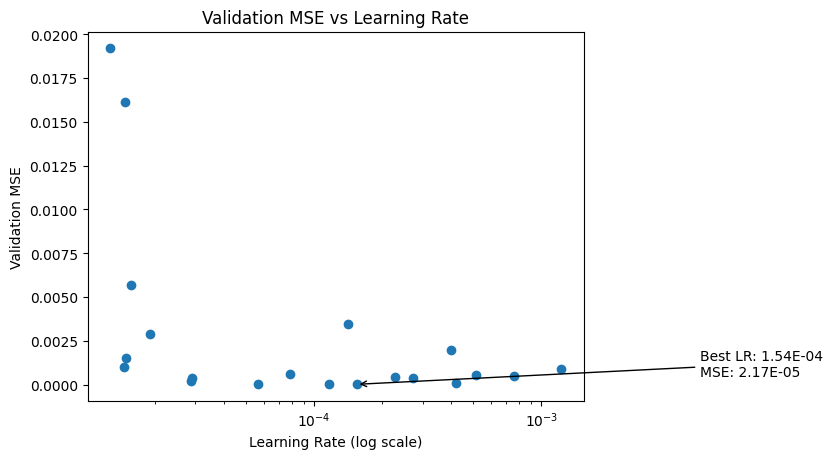

In [7]:
# Extract the learning rates and validation MSEs
learning_rates = [lr[0] for lr in lr_loss]
validation_mses = [lr[1] for lr in lr_loss]

# Find the index of the best learning rate and its corresponding validation MSE
best_idx = validation_mses.index(min(validation_mses))
best_lr = learning_rates[best_idx]
best_mse = validation_mses[best_idx]

# Create the scatter plot
plt.scatter(learning_rates, validation_mses)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs Learning Rate')

# Add the label for the best learning rate
plt.annotate(f'Best LR: {best_lr:.2E}\nMSE: {best_mse:.2E}', 
             xy=(best_lr, best_mse), xytext=(0.005, 0.0005),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()